In [4]:
import numpy as np
import pandas as pd
import gc
import time
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score 
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

import os
warnings.simplefilter(action='ignore', category=FutureWarning)

In [6]:
pd.set_option('max_columns',200)
pd.set_option('max_rows',200)

# Data preprocessing

There are 8 tables in total. Below are their relations with each other and data size.

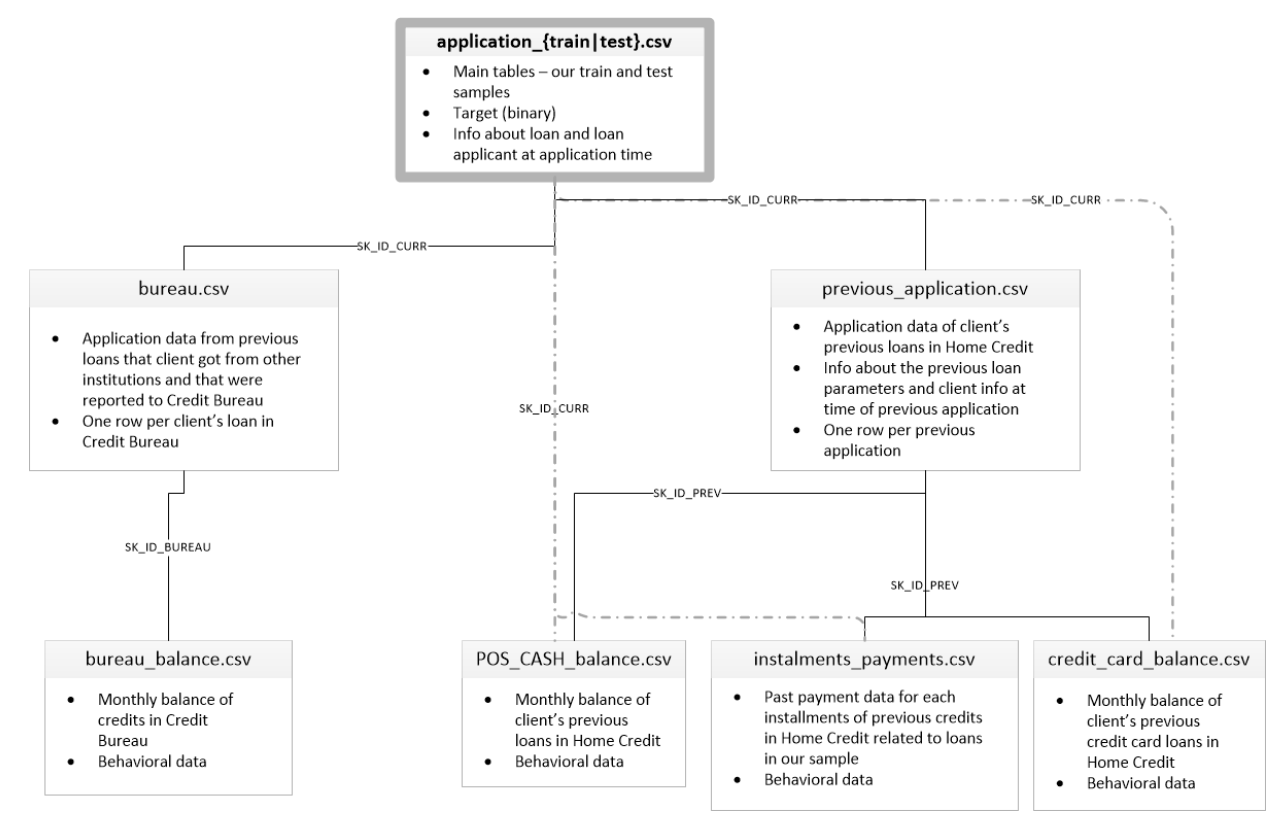

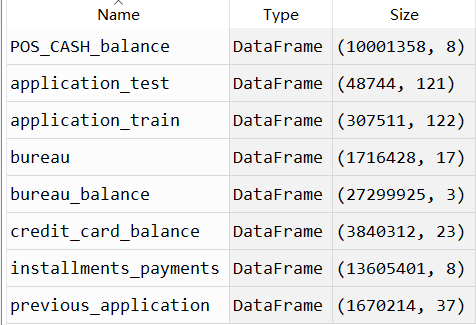

## Basic preprocessing functions


In [ ]:
def one_hot_encoder(df, nan_as_category=True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns=categorical_columns, dummy_na=nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

def categorical_to_numeric(series):
    class_mapping = {cls: value for value,cls in enumerate(series.unique())}
    series = series.map(class_mapping)
    return series


## application_train & application_test

In [5]:
df = pd.read_csv('application_train.csv')
test_df = pd.read_csv('application_test.csv')

In [13]:
# a glance at the data
df.iloc[:100]

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.000,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.0220,0.0198,0.0000,0.0000,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.0000,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.000,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.0790,0.0554,0.0000,0.0000,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.0100,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.000,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [16]:
test_df.iloc[:100]

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,Unaccompanied,Working,Higher education,Married,House / apartment,0.018850,-19241,-2329,-5170.0,-812,NaN,1,1,0,1,0,1,NaN,2.0,2,2,TUESDAY,18,0,0,0,0,0,0,Kindergarten,0.752614,0.789654,0.159520,0.0660,0.0590,0.9732,NaN,NaN,NaN,0.1379,0.1250,NaN,NaN,NaN,0.0505,NaN,NaN,0.0672,0.0612,0.9732,NaN,NaN,NaN,0.1379,0.1250,NaN,NaN,NaN,0.0526,NaN,NaN,0.0666,0.0590,0.9732,NaN,NaN,NaN,0.1379,0.1250,NaN,NaN,NaN,0.0514,NaN,NaN,NaN,block of flats,0.0392,"Stone, brick",No,0.0,0.0,0.0,0.0,-1740.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.035792,-18064,-4469,-9118.0,-1623,NaN,1,1,0,1,0,0,Low-skill Laborers,2.0,2,2,FRIDAY,9,0,0,0,0,0,0,Self-employed,0.564990,0.291656,0.432962,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,NaN,Working,Higher education,Married,House / apartment,0.019101,-20038,-4458,-2175.0,-3503,5.0,1,1,0,1,0,0,Drivers,2.0,2,2,MONDAY,14,0,0,0,0,0,0,Transport: type 3,NaN,0.699787,0.610991,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-856.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,Unaccompanied,Working,Secondary / secondary special,Marr

In [15]:
print(df.shape, '\n', test_df.shape)

(307511, 122) 
 (48744, 121)


In [ ]:
# Dealing with NaN values of CODE_GENDER
df['CODE_GENDER'].replace('XNA', 'F', inplace=True)
# Dealing withNaN values for DAYS_EMPLOYED: 365.243 -> nan
df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace=True)

docs = [_f for _f in df.columns if 'FLAG_DOC' in _f] 
live = [_f for _f in df.columns if ('FLAG_' in _f) & ('FLAG_DOC' not in _f) & ('_FLAG_' not in _f)] 

df[['FLAG_OWN_CAR','FLAG_OWN_REALTY']] = df[['FLAG_OWN_CAR','FLAG_OWN_REALTY']].apply(categorical_to_numeric, axis=0)
# Encode categorical features. I do not use the popuplar one-hot-encode since it lacks efficiency

def numeric_to_categorical(series, features):
    a = []
    for feature in features:
        if series[feature] == 1:
            a.append(feature.split("_")[-1])
    return str(a)
df['NEW_FLAG_DOCUMENT'] = df[docs].apply(numeric_to_categorical, axis=1, features=docs)
class_mapping = {cls: value for value,cls in enumerate(df['NEW_FLAG_DOCUMENT'].unique())}
df['NEW_FLAG_DOCUMENT'] = df['NEW_FLAG_DOCUMENT'].map(class_mapping)

df['NEW_FLAG_LIVING'] = df[live].apply(numeric_to_categorical, axis=1, features=live)
class_mapping = {cls: value for value,cls in enumerate(df['NEW_FLAG_LIVING'].unique())}
df['NEW_FLAG_LIVING'] = df['NEW_FLAG_LIVING'].map(class_mapping)


In [ ]:
# making some new features about money
df['NEW_CREDIT_TO_ANNUITY_RATIO'] = df['AMT_CREDIT'] / df['AMT_ANNUITY']  
df['NEW_CREDIT_TO_GOODS_RATIO'] = df['AMT_CREDIT'] / df['AMT_GOODS_PRICE']
df['NEW_CREDIT_TO_INCOME_RATIO'] = df['AMT_CREDIT'] / df['AMT_INCOME_TOTAL'] 
df['NEW_DOC_IND_KURT'] = df[docs].kurtosis(axis=1)
df['NEW_LIVE_IND_SUM'] = df[live].sum(axis=1)
df['NEW_INC_PER_CHLD'] = df['AMT_INCOME_TOTAL'] / (1 + df['CNT_CHILDREN'])  
df['NEW_ANNUITY_TO_INCOME_RATIO'] = df['AMT_ANNUITY'] / (1 + df['AMT_INCOME_TOTAL'])  

inc_by_org = df[['AMT_INCOME_TOTAL', 'ORGANIZATION_TYPE']].groupby('ORGANIZATION_TYPE').median()['AMT_INCOME_TOTAL']
df['NEW_INC_BY_ORG'] = df['ORGANIZATION_TYPE'].map(inc_by_org)

# making some new features about time period
df['NEW_EMPLOY_TO_BIRTH_RATIO'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH'] 
df['NEW_CAR_TO_BIRTH_RATIO'] = df['OWN_CAR_AGE'] / df['DAYS_BIRTH']  
df['NEW_CAR_TO_EMPLOY_RATIO'] = df['OWN_CAR_AGE'] / df['DAYS_EMPLOYED']  
df['NEW_PHONE_TO_BIRTH_RATIO'] = df['DAYS_LAST_PHONE_CHANGE'] / df['DAYS_BIRTH']
df['NEW_PHONE_TO_BIRTH_RATIO_EMPLOYER'] = df['DAYS_LAST_PHONE_CHANGE'] / df['DAYS_EMPLOYED'] 
df['NEW_PHONE_TO_ID_RATIO'] = df['DAYS_LAST_PHONE_CHANGE'] / df['DAYS_ID_PUBLISH']
df['NEW_PHONE_TO_REGISTRATION_RATIO'] = df['DAYS_LAST_PHONE_CHANGE'] / df['DAYS_REGISTRATION']
df['NEW_PHONE_TO_CAR_RATIO'] = df['DAYS_LAST_PHONE_CHANGE'] / df['OWN_CAR_AGE']

# making some new features about external sources
df['NEW_SOURCES_PROD'] = df['EXT_SOURCE_1'] * df['EXT_SOURCE_2'] * df['EXT_SOURCE_3']
df['NEW_EXT_SOURCES_MEAN'] = df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis=1)
df['NEW_SCORES_STD'] = df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].std(axis=1)
df['NEW_SCORES_STD'] = df['NEW_SCORES_STD'].fillna(df['NEW_SCORES_STD'].mean())
df['NEW_SCORES_SUM'] = df['EXT_SOURCE_1'] +df['EXT_SOURCE_2'] +df['EXT_SOURCE_3'] 

# information about thest FLAG_DOCUMENT features has been extracted
dropcolum = ['FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_4',
             'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_7',
             'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_10',
             'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13',
             'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16',
             'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19',
             'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21']  
df = df.drop(dropcolum, axis=1)
del test_df
gc.collect()

## bureau & bureau_balance

In [18]:
bureau = pd.read_csv("bureau.csv")
bb = pd.read_csv("bureau_balance.csv")

In [11]:
bureau.iloc[0:120]

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.000,0.000,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.000,171342.000,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.500,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.000,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.500,0,2700000.000,NaN,NaN,0.0,Consumer credit,-21,NaN
5,215354,5714467,Active,currency 1,-273,0,27460.0,NaN,0.000,0,180000.000,71017.380,108982.620,0.0,Credit card,-31,NaN
6,215354,5714468,Active,currency 1,-43,0,79.0,NaN,0.000,0,42103.800,42103.800,0.000,0.0,Consumer credit,-22,NaN
7,162297,5714469,Closed,currency 1,-1896,0,-1684.0,-1710.0,14985.000,0,76878.450,0.000,0.000,0.0,Consumer credit,-1710,NaN
8,162297,5714470,Closed,currency 1,-1146,0,-811.0,-840.0,0.000,0,103007.700,0.000,0.000,0.0,Consumer credit,-840,NaN
9,162297,5714471,Active,currency 1,-1146,0,-484.0,NaN,0.000,0,4500.000,0.000,0.000,0.0,Credit card,-690,NaN


In [9]:
bb.iloc[0:130]

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C
5,5715448,-5,C
6,5715448,-6,C
7,5715448,-7,C
8,5715448,-8,C
9,5715448,-9,0


In [21]:
print(bureau.shape, '\n', bb.shape)

(1716428, 17) 
 (27299925, 3)


In [ ]:
bb, bb_cat = one_hot_encoder(bb)
bureau, bureau_cat = one_hot_encoder(bureau)

# Bureau balance: Perform aggregations and merge with bureau
bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
for col in bb_cat:
    bb_aggregations[col] = ['mean']
bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])

bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
bureau.drop(['SK_ID_BUREAU'], axis=1, inplace=True)
del bb, bb_agg
gc.collect()

In [ ]:
# create weighted features
bureau['weight'] = bureau[['SK_ID_CURR','DAYS_CREDIT']].groupby('SK_ID_CURR').apply(lambda x: 1-abs(x)/x.sum().abs()).iloc[:,1]
bureau['CREDIT_DAY_OVERDUE_WEIGHTED'] = bureau['CREDIT_DAY_OVERDUE']*bureau['weight']
bureau['AMT_CREDIT_MAX_OVERDUE_WEIGHTED'] = bureau['AMT_CREDIT_MAX_OVERDUE']*bureau['weight']
bureau['AMT_CREDIT_SUM_WEIGHTED'] = bureau['AMT_CREDIT_SUM']*bureau['weight']
bureau['AMT_CREDIT_SUM_DEBT_WEIGHTED'] = bureau['AMT_CREDIT_SUM_DEBT']*bureau['weight']
bureau['AMT_CREDIT_SUM_OVERDUE_WEIGHTED'] = bureau['AMT_CREDIT_SUM_OVERDUE']*bureau['weight']
bureau['AMT_CREDIT_SUM_LIMIT_WEIGHTED'] = bureau['AMT_CREDIT_SUM_LIMIT']*bureau['weight']
bureau['AMT_ANNUITY_WEIGHTED'] = bureau['AMT_ANNUITY']*bureau['weight']
bureau['CNT_CREDIT_PROLONG_WEIGHTED'] = bureau['CNT_CREDIT_PROLONG']*bureau['weight']

In [ ]:
# Bureau and bureau_balance numeric features
num_aggregations = {
    'DAYS_CREDIT': ['mean', 'var'],
    'DAYS_CREDIT_ENDDATE': ['mean'],
    'DAYS_CREDIT_UPDATE': ['mean'],

    'CREDIT_DAY_OVERDUE': ['mean'],
    'AMT_CREDIT_MAX_OVERDUE': ['mean'],
    'AMT_CREDIT_SUM': ['mean', 'sum'],
    'AMT_CREDIT_SUM_DEBT': ['mean', 'sum'],
    'AMT_CREDIT_SUM_OVERDUE': ['mean'],
    'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
    'AMT_ANNUITY': ['max', 'mean'],
    'CNT_CREDIT_PROLONG': ['sum'],
    # weighted features
    'CREDIT_DAY_OVERDUE_WEIGHTED': ['mean'],
    'AMT_CREDIT_MAX_OVERDUE_WEIGHTED': ['mean'],
    'AMT_CREDIT_SUM_WEIGHTED': ['mean', 'sum'],
    'AMT_CREDIT_SUM_DEBT_WEIGHTED': ['mean', 'sum'],
    'AMT_CREDIT_SUM_OVERDUE_WEIGHTED': ['mean'],
    'AMT_CREDIT_SUM_LIMIT_WEIGHTED': ['mean', 'sum'],
    'AMT_ANNUITY_WEIGHTED': ['max', 'mean'],
    'CNT_CREDIT_PROLONG_WEIGHTED': ['sum'],
    # bureau balance
    'MONTHS_BALANCE_MIN': ['min'],
    'MONTHS_BALANCE_MAX': ['max'],
    'MONTHS_BALANCE_SIZE': ['mean', 'sum']
}
# Bureau and bureau_balance categorical features
cat_aggregations = {}
for cat in bureau_cat: cat_aggregations[cat] = ['mean']
for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']

bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])

In [ ]:
# Bureau: Active credits - using only numerical aggregations
active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
bureau_agg = bureau_agg.join(active_agg, how='left')
del active, active_agg
gc.collect()

# Bureau: Closed credits - using only numerical aggregations
closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
bureau_agg = bureau_agg.join(closed_agg, how='left')
del closed, closed_agg, bureau
gc.collect()

df = df.join(bureau_agg, how='left', on='SK_ID_CURR') # merge with the main table

## credit_card.balance

In [22]:
cc = pd.read_csv("credit_card_balance.csv")

In [23]:
# a glance of the data
cc.sort_values(by=['SK_ID_CURR','SK_ID_PREV','MONTHS_BALANCE']).iloc[0:130]

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
1636141,1489396,100006,-6,0.000,270000,NaN,0.0,NaN,NaN,0.000,NaN,0.000,0.000,0.000,0.000,NaN,0,NaN,NaN,0.0,Active,0,0
655566,1489396,100006,-5,0.000,270000,NaN,0.0,NaN,NaN,0.000,NaN,0.000,0.000,0.000,0.000,NaN,0,NaN,NaN,0.0,Active,0,0
1399895,1489396,100006,-4,0.000,270000,NaN,0.0,NaN,NaN,0.000,NaN,0.000,0.000,0.000,0.000,NaN,0,NaN,NaN,0.0,Active,0,0
1347528,1489396,100006,-3,0.000,270000,NaN,0.0,NaN,NaN,0.000,NaN,0.000,0.000,0.000,0.000,NaN,0,NaN,NaN,0.0,Active,0,0
520387,1489396,100006,-2,0.000,270000,NaN,0.0,NaN,NaN,0.000,NaN,0.000,0.000,0.000,0.000,NaN,0,NaN,NaN,0.0,Active,0,0
584804,1489396,100006,-1,0.000,270000,NaN,0.0,NaN,NaN,0.000,NaN,0.000,0.000,0.000,0.000,NaN,0,NaN,NaN,0.0,Active,0,0
3131464,1843384,100011,-75,189000.000,180000,180000.0,180000.0,0.0,0.0,NaN,0.000,0.000,180000.000,189000.000,189000.000,4.0,4,0.0,0.0,NaN,Active,0,0
2447092,1843384,100011,-74,184568.850,180000,0.0,0.0,0.0,0.0,9000.000,9000.000,9000.000,180000.000,184568.850,184568.850,0.0,0,0.0,0.0,1.0,Active,0,0
2353190,1843384,100011,-73,181044.540,180000,0.0,0.0,0.0,0.0,9000.000,9000.000,9000.000,175568.850,181044.540,181044.540,0.0,0,0.0,0.0,2.0,Active,0,0
1086495,1843384,100011,-72,177544.350,180000,0.0,0.0,0.0,0.0,9000.000,9000.000,9000.000,172044.540,177544.350,177544.350,0.0,0,0.0,0.0,3.0,Active,0,0


In [24]:
cc.shape

(3840312, 23)

In [ ]:
cc, cat_cols = one_hot_encoder(cc, nan_as_category=True)

# General aggregations
cc.drop(['SK_ID_PREV'], axis=1, inplace=True)
cc_agg = cc.groupby('SK_ID_CURR').agg(['max', 'mean', 'sum', 'var'])
cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
# Count credit card lines
cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
del cc
gc.collect()

df = df.join(cc_agg, how='left', on='SK_ID_CURR') # merge with the main table

## instalments_payments

In [25]:
ins = pd.read_csv("installments_payments.csv")

In [26]:
# a glance at the data
ins.sort_values(by=['SK_ID_CURR','SK_ID_PREV','NUM_INSTALMENT_NUMBER']).iloc[0:130]

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
1478621,1369693,100001,1.0,1,-1709.0,-1715.0,3951.000,3951.000
2568722,1369693,100001,1.0,2,-1679.0,-1715.0,3951.000,3951.000
3458712,1369693,100001,1.0,3,-1649.0,-1660.0,3951.000,3951.000
2624024,1369693,100001,2.0,4,-1619.0,-1628.0,17397.900,17397.900
1761012,1851984,100001,1.0,2,-2916.0,-2916.0,3982.050,3982.050
3774071,1851984,100001,1.0,3,-2886.0,-2875.0,3982.050,3982.050
3435373,1851984,100001,1.0,4,-2856.0,-2856.0,3980.925,3980.925
2144879,1038818,100002,1.0,1,-565.0,-587.0,9251.775,9251.775
2163032,1038818,100002,1.0,2,-535.0,-562.0,9251.775,9251.775
1675768,1038818,100002,1.0,3,-505.0,-529.0,9251.775,9251.775


In [27]:
ins.shape

(13605401, 8)

In [ ]:
ins, cat_cols = one_hot_encoder(ins, nan_as_category=True)
# Percentage and difference paid in each installment (amount paid and installment value)
ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']  
ins['PAYMENT_DIFF_PERC'] = ins['PAYMENT_DIFF'] / ins['AMT_INSTALMENT']

# Days past due and days before due (no negative values)
ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)

# Create weighted features
ins['weight'] = ins[['SK_ID_PREV', 'DAYS_ENTRY_PAYMENT']].groupby('SK_ID_PREV').apply(lambda x: 1-abs(x)/x.sum().abs()).iloc[:,1]
ins['DPD_WEIGHTED'] = ins['DPD'] * ins['weight']
ins['DBD_WEIGHTED'] = ins['DBD'] * ins['weight']
ins['PAYMENT_PERC_WEIGHTED'] = ins['PAYMENT_PERC'] * ins['weight']
ins['PAYMENT_DIFF_WEIGHTED'] = ins['PAYMENT_DIFF'] * ins['weight']
ins['PAYMENT_DIFF_PERC_WEIGHTED'] = ins['PAYMENT_DIFF_PERC'] * ins['weight']

# Features: Perform aggregations
aggregations = {
    'NUM_INSTALMENT_VERSION': ['nunique'],
    'DPD': ['max', 'mean', 'sum', 'min', 'std'],
    'DBD': ['max', 'mean', 'sum', 'min', 'std'],
    'PAYMENT_PERC': ['max', 'mean', 'var', 'min', 'std'],
    'PAYMENT_DIFF': ['max', 'mean', 'var', 'min', 'std'],
    'AMT_INSTALMENT': ['max', 'mean', 'sum', 'min', 'std'],
    'AMT_PAYMENT': ['min', 'max', 'mean', 'sum', 'std'],
    'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum', 'std'],
    
    'DPD_WEIGHTED': ['max', 'mean', 'sum', 'min', 'std'],
    'DBD_WEIGHTED': ['max', 'mean', 'sum', 'min', 'std'],
    'PAYMENT_PERC_WEIGHTED': ['max', 'mean', 'var', 'min', 'std'],
    'PAYMENT_DIFF_WEIGHTED': ['max', 'mean', 'var', 'min', 'std'],
    'PAYMENT_DIFF_PERC': ['max', 'mean', 'var', 'min', 'std'],
    'PAYMENT_DIFF_PERC_WEIGHTED': ['max', 'mean', 'var', 'min', 'std']
     }

ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
# Count installments accounts
ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
del ins
gc.collect()

df = df.join(ins_agg, how='left', on='SK_ID_CURR') # merge with the main table

## previous_application

In [28]:
prev = pd.read_csv("previous_application.csv")

In [4]:
# a glance at the data
prev.sort_values(by=['SK_ID_CURR']).iloc[0:130]

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
201668,1369693,100001,Consumer loans,3951.000,24835.500,23787.000,2520.00,24835.500,FRIDAY,13,Y,1,0.104326,NaN,NaN,XAP,Approved,-1740,Cash through the bank,XAP,Family,Refreshed,Mobile,POS,XNA,Country-wide,23,Connectivity,8.0,high,POS mobile with interest,365243.0,-1709.0,-1499.0,-1619.0,-1612.0,0.0
892077,1038818,100002,Consumer loans,9251.775,179055.000,179055.000,0.00,179055.000,SATURDAY,9,Y,1,0.000000,NaN,NaN,XAP,Approved,-606,XNA,XAP,NaN,New,Vehicles,POS,XNA,Stone,500,Auto technology,24.0,low_normal,POS other with interest,365243.0,-565.0,125.0,-25.0,-17.0,0.0
575941,1810518,100003,Cash loans,98356.995,900000.000,1035882.000,NaN,900000.000,FRIDAY,12,Y,1,NaN,NaN,NaN,XNA,Approved,-746,XNA,XAP,Unaccompanied,Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,low_normal,Cash X-Sell: low,365243.0,-716.0,-386.0,-536.0,-527.0,1.0
1021650,2636178,100003,Consumer loans,64567.665,337500.000,348637.500,0.00,337500.000,SUNDAY,17,Y,1,0.000000,NaN,NaN,XAP,Approved,-828,Cash through the bank,XAP,Family,Refreshed,Furniture,POS,XNA,Stone,1400,Furniture,6.0,middle,POS industry with interest,365243.0,-797.0,-647.0,-647.0,-639.0,0.0
1223745,2396755,100003,Consumer loans,6737.310,68809.500,68053.500,6885.00,68809.500,SATURDAY,15,Y,1,0.100061,NaN,NaN,XAP,Approved,-2341,Cash through the bank,XAP,Family,Refreshed,Consumer Electronics,POS,XNA,Country-wide,200,Consumer electronics,12.0,middle,POS household with interest,365243.0,-2310.0,-1980.0,-1980.0,-1976.0,1.0
935548,1564014,100004,Consumer loans,5357.250,24282.000,20106.000,4860.00,24282.000,FRIDAY,5,Y,1,0.212008,NaN,NaN,XAP,Approved,-815,Cash through the bank,XAP,Unaccompanied,New,Mobile,POS,XNA,Regional / Local,30,Connectivity,4.0,middle,POS mobile without interest,365243.0,-784.0,-694.0,-724.0,-714.0,0.0
1259112,1857999,100005,Cash loans,NaN,0.000,0.000,NaN,NaN,FRIDAY,10,Y,1,NaN,NaN,NaN,XNA,Canceled,-315,XNA,XAP,NaN,Repeater,XNA,XNA,XNA,Credit and cash offices,-1,XNA,NaN,XNA,Cash,NaN,NaN,NaN,NaN,NaN,NaN
1378978,2495675,100005,Consumer loans,4813.200,44617.500,40153.500,4464.00,44617.500,THURSDAY,11,Y,1,0.108964,NaN,NaN,XAP,Approved,-757,Cash through the bank,XAP,NaN,New,Mobile,POS,XNA,Country-wide,37,Connectivity,12.0,high,POS mobile with interest,365243.0,-706.0,-376.0,-466.0,-460.0,0.0
900957,1489396,100006,Revolving loans,13500.000,270000.000,270000.000,NaN,270000.000,THURSDAY,15,Y,1,NaN,NaN,NaN,XAP,Approved,-181,XNA,XAP,Unaccompanied,Repeater,XNA,Cards,x-sell,Credit and cash offices,-1,XNA,0.0,XNA,Card X-Sell,365243.0,365243.0,365243.0,365243.0,365243.0,0.0
1607443,1697039,100006,Cash loans,32696.100,688500.000,906615.000,NaN,688500.000,THURSDAY,15,Y,1,NaN,NaN,NaN,XNA,Refused,-181,Cash through the bank,LIMIT,Unaccompanied,Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,48.0,low_normal,Cash X-Sell: low,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
prev, cat_cols = one_hot_encoder(prev, nan_as_category=True)

# Wrong values: Days 365.243 values -> nan
prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace=True)
prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace=True)
prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace=True)
prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace=True)
prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace=True)

# Add features
prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
prev['weight'] = prev[['SK_ID_CURR','DAYS_DECISION']].groupby('SK_ID_CURR').apply(lambda x: 1-abs(x)/x.sum().abs()).iloc[:,1]
prev['AMT_ANNUITY_WEIGHTED'] = prev['AMT_ANNUITY']*prev['weight']
prev['AMT_APPLICATION_WEIGHTED'] = prev['AMT_APPLICATION']*prev['weight']
prev['AMT_CREDIT_WEIGHTED'] = prev['AMT_CREDIT']*prev['weight']
prev['APP_CREDIT_PERC_WEIGHTED'] = prev['AMT_APPLICATION_WEIGHTED'] / prev['AMT_CREDIT_WEIGHTED']
prev['AMT_DOWN_PAYMENT_WEIGHTED'] = prev['AMT_DOWN_PAYMENT']*prev['weight']
prev['AMT_GOODS_PRICE_WEIGHTED'] = prev['AMT_GOODS_PRICE']*prev['weight']
prev['RATE_DOWN_PAYMENT_WEIGHTED'] = prev['RATE_DOWN_PAYMENT']*prev['weight']
prev['CNT_PAYMENT_WEIGHTED'] = prev['CNT_PAYMENT']*prev['weight']

In [ ]:
# Previous applications numeric features
num_aggregations = {
    'AMT_ANNUITY': ['max', 'mean'],
    'AMT_APPLICATION': ['max', 'mean'],
    'AMT_CREDIT': ['max', 'mean'],
    'APP_CREDIT_PERC': ['max', 'mean'],
    'AMT_DOWN_PAYMENT': ['max', 'mean'],
    'AMT_GOODS_PRICE': ['max', 'mean'],
    'HOUR_APPR_PROCESS_START': ['max', 'mean'],
    'RATE_DOWN_PAYMENT': ['max', 'mean'],
    'DAYS_DECISION': ['max', 'mean'],
    'CNT_PAYMENT': ['mean', 'sum'],
    # weighted features
    'AMT_ANNUITY_WEIGHTED': ['max', 'mean'],
    'AMT_APPLICATION_WEIGHTED': ['max', 'mean'],
    'AMT_CREDIT_WEIGHTED': ['max', 'mean'],
    'APP_CREDIT_PERC_WEIGHTED': ['max', 'mean'],
    'AMT_DOWN_PAYMENT_WEIGHTED': ['max', 'mean'],
    'AMT_GOODS_PRICE_WEIGHTED': ['max', 'mean'],
    'RATE_DOWN_PAYMENT_WEIGHTED': ['max', 'mean'],
    'CNT_PAYMENT_WEIGHTED': ['mean', 'sum']
    }

# Previous applications categorical features
cat_aggregations = {}
for cat in cat_cols:
    cat_aggregations[cat] = ['mean']

prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])

In [ ]:
# Previous Applications: Approved Applications - only numerical features
approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
prev_agg = prev_agg.join(approved_agg, how='left')

# Previous Applications: Refused Applications - only numerical features
refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
prev_agg = prev_agg.join(refused_agg, how='left')

del refused, refused_agg, approved, approved_agg, prev
gc.collect()

df = df.join(prev_agg, how='left', on='SK_ID_CURR') # merge with the main table

## POS_CASH_balance

In [29]:
pos = pd.read_csv("POS_CASH_balance.csv")

In [12]:
# a glance at the data
pos.sort_values(by=['SK_ID_CURR','SK_ID_PREV','MONTHS_BALANCE']).iloc[0:130]

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
7167007,1369693,100001,-57,4.0,4.0,Active,0,0
8789081,1369693,100001,-56,4.0,3.0,Active,0,0
7823681,1369693,100001,-55,4.0,2.0,Active,0,0
4704415,1369693,100001,-54,4.0,1.0,Active,0,0
2197888,1369693,100001,-53,4.0,0.0,Completed,0,0
1261679,1851984,100001,-96,4.0,2.0,Active,0,0
1891462,1851984,100001,-95,4.0,1.0,Active,7,7
8531326,1851984,100001,-94,4.0,0.0,Active,0,0
4928574,1851984,100001,-93,4.0,0.0,Completed,0,0
8473918,1038818,100002,-19,24.0,24.0,Active,0,0


In [31]:
pos.shape

(10001358, 8)

In [ ]:
pos, cat_cols = one_hot_encoder(pos, nan_as_category=True)

# Features aggregations
aggregations = {
    'MONTHS_BALANCE': ['max', 'mean', 'size'],
    'SK_DPD': ['max', 'mean'],
    'SK_DPD_DEF': ['max', 'mean']
}
for cat in cat_cols:
    aggregations[cat] = ['mean']

pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])

# Count pos cash accounts
pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
del pos
gc.collect()

df = df.join(pos_agg, how='left', on='SK_ID_CURR') # merge with the main table

# LightGBM

In [ ]:
del bureau_agg, cc_agg, ins_agg, pos_agg, prev_agg

categorical_features = [col for col in df.columns if df[col].dtype=='object']
categorical_features.append('NEW_FLAG_DOCUMENT')
categorical_features.append('NEW_FLAG_LIVING')

df[categorical_features] = df[categorical_features].apply(categorical_to_numeric, axis=0)

train_df = df[df['TARGET'].notnull()]
test_df = df[df['TARGET'].isnull()]

print("Starting LightGBM. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))
del df
gc.collect()

In [ ]:
num_folds = 5 # CV folds
folds = KFold(n_splits=num_folds, shuffle=True, random_state=47)
    
# Create arrays and dataframes to store results
oof_preds = np.zeros(train_df.shape[0])
sub_preds = np.zeros(test_df.shape[0])
feature_importance_df = pd.DataFrame()
feats = [f for f in train_df.columns if f not in ['TARGET', 'SK_ID_CURR', 'SK_ID_BUREAU', 'SK_ID_PREV', 'index']]

for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
    train_x, train_y = train_df[feats].iloc[train_idx], train_df['TARGET'].iloc[train_idx]
    valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx]

    t0 = time.time()
    print("fold: ", n_fold)

    # LightGBM parameters found by Bayesian optimization
    clf = LGBMClassifier(
        nthread=4,
        n_estimators=10000,
        learning_rate=0.02,
        # is_unbalance=True,
        num_leaves=32,
        colsample_bytree=0.9497036,
        subsample=0.8715623,
        max_depth=8,
        reg_alpha=0.04,
        reg_lambda=0.073,
        min_split_gain=0.0222415,
        min_child_weight=40,
        silent=-1,
        verbose=-1,
        # scale_pos_weight=11
    )

    clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)],
            categorical_feature=categorical_features,
            eval_metric='auc', verbose=100, early_stopping_rounds=100)

    print("time used:",(time.time()-t0)/60)
    record[:,n_fold] = clf.predict_proba(test_df[feats], num_iteration=clf.best_iteration_)[:, 1]

    oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]
    sub_preds += clf.predict_proba(test_df[feats], num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits

    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = feats
    fold_importance_df["importance"] = clf.feature_importances_
    fold_importance_df["fold"] = n_fold + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))
    del clf, train_x, train_y, valid_x, valid_y
    gc.collect()

print('Full AUC score %.6f' % roc_auc_score(train_df['TARGET'], oof_preds))

# Write submission file and plot feature importance
test_df['TARGET'] = sub_preds
test_df[['SK_ID_CURR', 'TARGET']].to_csv("submission.csv", index=False)

In [ ]:
def display_importances(feature_importance_df):
    cols = feature_importance_df[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance",ascending=False)[:70].index
    best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances01.png')

In [32]:
display_importances(feature_importance_df)

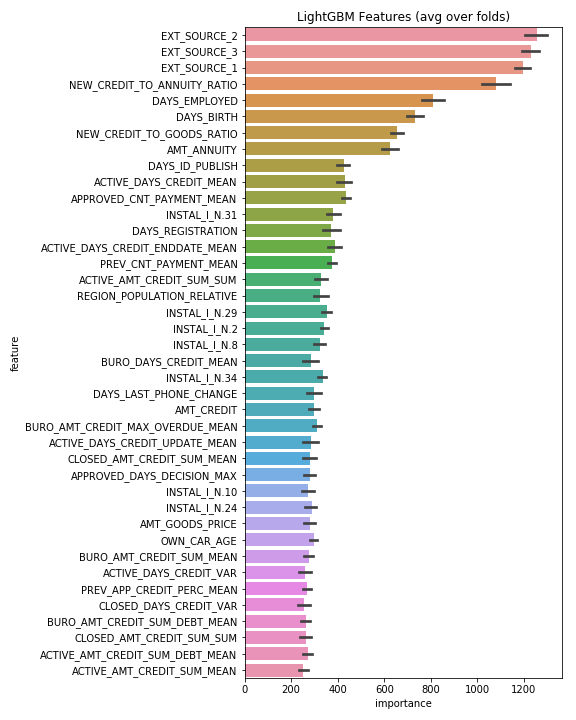